In [1]:
import os
import numpy as np
import pandas as pd
import SimpleITK as sitk
import matplotlib.pyplot as plt

In [6]:
def plot_hists(images1, images2=None):
    plt.hist(images1.ravel(), bins=100, density=True, color='b', alpha=1 if images2 is None else 0.5)
    if images2 is not None:
        plt.hist(images2.ravel(), bins=100, density=True, alpha=0.5, color='orange')
    plt.show()

In [7]:
def window_transform(ct_array, windowWidth, windowCenter, normal=False):
	"""
    return: trucated image according to window center and window width
    and normalized to [0,1]
    """
	minWindow = float(windowCenter) - 0.5*float(windowWidth)
	# print(minWindow)
	newimg = (ct_array - minWindow) / float(windowWidth)
	newimg[newimg < 0] = 0
	newimg[newimg > 1] = 1
	if not normal:
		newimg = (newimg * 255).astype('uint8')
	return newimg

coronacases的ct调整肺窗到[-1250, 250]
参考该链接中说法进行的调整：https://gitee.com/junma11/COVID-19-CT-Seg-Benchmark

In [ ]:
# 肺窗调整到[-1250, 250]

data_path = "E:/dataset/COVID-19-CT-Seg_20cases/"
ct_path = os.path.join(data_path, "ct_scans")
lung_path = os.path.join(data_path, "Lung_Mask")

In [12]:
data_dict = {}
image_save_path = "./data/ct_scans/"
l_r_mask_save_path = "./data/r_l_lung/"
lung_mask_save_path = "./data/lung_mask/"

for file in os.listdir(ct_path):
    if file == "ReadMe.txt":
        continue
    filename = file.split(".")
    ct = sitk.ReadImage(os.path.join(ct_path, file))
    ct_array = sitk.GetArrayFromImage(ct)
    if not file.startswith("ra"):
        ct_array = window_transform(ct_array * 1.0, 1500, -500)
    
    lung_mask = sitk.ReadImage(os.path.join(lung_path, file))
    lung_mask_arr = sitk.GetArrayFromImage(lung_mask)
    print(file, ct_array.shape, np.max(ct_array), np.min(ct_array))
    
    print(np.unique(lung_mask_arr))
    
    lung_mask_single = lung_mask_arr.copy()
    lung_mask_single[lung_mask_single == 2] = 1
    data_list = []
    for i in range(ct_array.shape[0]):
        if np.max(lung_mask_single[i]) > 0:
            image_path = os.path.join(image_save_path, "{}_{}.npy".format(filename[0], i))
            r_l_mask_path = os.path.join(l_r_mask_save_path, "{}_{}.npy".format(filename[0], i))
            lung_mask_path = os.path.join(lung_mask_save_path, "{}_{}.npy".format(filename[0], i))
            
            np.save(image_path, ct_array[i])
            np.save(r_l_mask_path, lung_mask[i])
            np.save(lung_mask_path, lung_mask_single[i])
            
            data_list.append({
                "image_path": image_path,
                "r_l_mask": r_l_mask_path,
                "lung_mask": lung_mask_path,
            })
        else:
            continue
    data_dict[filename[0]] = data_list
    break

coronacases_001.nii.gz (301, 512, 512) 255 38
[0 1 2]


In [13]:
import json
with open("test.json", 'w', encoding='utf-8') as f:
    f.write(json.dumps(data_dict))

In [15]:
key_list = list(data_dict.keys())

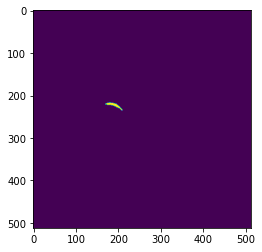

In [16]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(key_list, test_size=0.2, random_state=101)
train, valid = train_test_split(train, test_size=0.1, random_state=1)
print(train)
print(valid)
print(test)

In [ ]:
train_data = []
for item in train:
    train_data += data_dict[item]
with open("lung_seg_train.json", "w", encoding="utf-8") as f:
    f.write(json.dumps(train_data))

In [ ]:
valid_data = []
for item in valid:
    valid_data += data_dict[item]
with open("lung_seg_valid.json", "w", encoding="utf-8") as f:
    f.write(json.dumps(valid_data))

In [ ]:
test_data = []
for item in test:
    test_data += data_dict[item]
with open("lung_seg_test.json", "w", encoding="utf-8") as f:
    f.write(json.dumps(test_data))

In [ ]:
image = np.load("")
mask = np.load("")
if np.max(image) < 2.0:
    image = image*255.0
image = image[:, :, np.newaxis]
mask = mask[:, :, np.newaxis]

image = np.expand_dims(image, axis=0).astype(np.float32)
mask = np.expand_dims(mask, axis=0).astype(np.int32)
seq2 = iaa.Sequential([iaa.Resize({"height": 224, "width": 224},  interpolation='area')])
image, mask = seq2(images=image, segmentation_maps=mask)
image = image[0, :, :, 0]
mask = mask[0, :, :, 0]
image = Image.fromarray(image).convert('L')
mask = Image.fromarray(mask).convert('L')